In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

from collections.abc import Iterable
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
from torchvision.utils import make_grid

In [8]:
class ColorImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2RGB, transform=transforms.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(f'{path}/{file}') for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]

        self.imgs = imgs
        self.transform = transform
        self.channels = {'r':0, 'g':1, 'b':2}

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
                return imgs
        else:
            return self.transform(self.imgs[subscript])

    def __call__(self, color):
        try:
            imgs = []
            for img in self.imgs:
                img = img[:, :, self.channels[color]]
                img = self.transform(img)
                imgs.append(img)

            return imgs
        except IndexError:
            raise ValueError('Only one color channel is available.', )


#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [9]:
class OpenCVResize(object):

    def __init__(self, size):
        assert isinstance(size, int) or isinstance(size, Iterable) and len(size) == 2
        self.size = size

    def __call__(self, pic):
        return cv2.resize(pic, dsize=self.size, interpolation=cv2.INTER_NEAREST)


In [10]:
tf = transforms.Compose({
    OpenCVResize(size=(1280, 720)),
    transforms.ToTensor()
})

gray_dataset = ColorImageDataset(path='../dataset/color', transform=tf, code=cv2.COLOR_BGR2GRAY)
color_dataset = ColorImageDataset(path='../dataset/color', transform=tf, code=cv2.COLOR_BGR2RGB)

In [11]:
torch.manual_seed(72)

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=12, shuffle=False)
# COLOR IMAGES JUST FOR VISUALIZATION PURPOSE.
color_data_loader = DataLoader(dataset=color_dataset, batch_size=12, shuffle=False)

#### View a single batch grayscale and colored image sample.

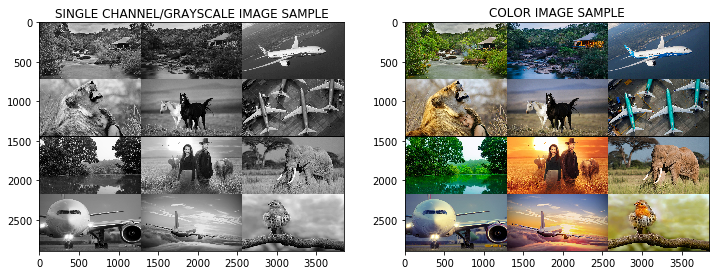

In [12]:
g_ims, c_ims = None, None
for g_ims in gray_data_loader:
    break

for c_ims in color_data_loader:
    break

plt.figure(figsize=(12, 10))

im = make_grid(g_ims, nrow=3, normalize=True)

plt.subplot(121)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(c_ims, nrow=3, normalize=True)

plt.subplot(122)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("COLOR IMAGE SAMPLE")
plt.show()

#### Derive color channels individually from colored images includes a visualization.

In [13]:
torch.manual_seed(72)

red_loader = DataLoader(dataset=color_dataset(color='r'), batch_size=12, shuffle=False)
green_loader = DataLoader(dataset=color_dataset(color='g'), batch_size=12, shuffle=False)
blue_loader = DataLoader(dataset=color_dataset(color='b'), batch_size=12, shuffle=False)

In [15]:
r_img, g_img, b_img = None, None, None
for r_img in red_loader:
    break

for g_img in green_loader:
    break

for b_img in blue_loader:
    break

len(red_loader)

5

In [ ]:
plt.imshow(images[0].view(720, -1), cmap='nipy_spectral')
plt.colorbar()